In [73]:
%load_ext autoreload
%autoreload 2
import sys, os, glob, re, pickle, scipy
from collections import defaultdict
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 300)
from openbabel import openbabel as ob
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

sys.path.append('/net/pulsar/home/koes/mtr22/param_search')
import param_search

os.chdir(os.environ['LIGAN_ROOT'])
import liGAN

os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/net/pulsar/home/koes/mtr22/gan'

In [138]:
def find_work_dir(x):
    if 'work_dir' in x and not pd.isnull(x['work_dir']):
        return x['work_dir']
    f = glob.glob('*/{}.*'.format(x['job_id']))
    if f:
        return os.path.dirname(f[0])
    # else cancelled before running

def find_job_state(x):
    if 'job_state' in x and not pd.isnull(x['job_state']):
        return x['job_state']
    if x['work_dir'] is None:
        return 'CAN'
    if x['stderr'] is not None:
        return 'ERR'
    return 'OK'

def catch_exc(func, exc_type=Exception, default=None):
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except exc_type as e:
            return default
    return wrapper

def get_palette(n_hues, n_shades=1, n_repeat=1, hues=None, min_val=0.0, max_val=1.0, n_samples=100, mode=None):
    assert 0 <= min_val <= 1.0
    assert 0 <= max_val <= 1.0
    
    if hues is None:
        if n_hues <= 9:
            mode = mode or 'muted'
            hues = sns.color_palette(mode)[:n_hues]
        else:
            mode = mode or 'husl'
            hues = sns.color_palette(mode, n_hues)

    colors = []
    for hue in hues:
        
        # get n_samples different shades of hue
        shades = (
            sns.dark_palette(hue, n_colors=n_samples//2) + \
            sns.light_palette(hue, n_colors=n_samples//2, reverse=True)
        )
        # limit shade range with min_val and max_val
        min_idx = int(min_val * len(shades))
        max_idx = int(max_val * len(shades))
        shades = shades[min_idx:max_idx]
        
        # get n_shades evenly spaced shades in that range, avoiding endpoints
        vals = np.linspace(0, 1, n_shades + 2)
        idxs = [int(v * (len(shades) - 1)) for v in vals]
        shades = [shades[i] for i in idxs[1:-1]]
        
        # repeat each shade n_repeat times
        shades = sorted(n_repeat * shades, key=lambda x: sum(x))

        colors.extend(shades)
        
    return sns.color_palette(colors)

add_expt_dir = os.path.join(os.environ['LIGAN_ROOT'], 'new_atom_typing')

get_palette(6, 3, mode='deep')

[(0.21829099296123639, 0.2944934094810203, 0.42176143091666507),
 (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.613444549489308, 0.6904250129735933, 0.8170572004996018),
 (0.5083177616805236, 0.32698776572630495, 0.22751769795377563),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.9074107005425347, 0.7256631691257395, 0.6244940441782509),
 (0.2335650595670791, 0.40010407390509417, 0.2712320220955903),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.6241958472503204, 0.801414966799042, 0.6639455297550778),
 (0.46512753037574767, 0.22127745821131717, 0.22928300397666584),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.8567025971189416, 0.6177932289099055, 0.6257817602688556),
 (0.32409279213910397, 0.2931729441494827, 0.42896696886408636),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.7205291643190892, 0.69018744433034, 0.8221040075757725),
 (0.3607247926919744, 0.3054219010216468, 0.2568614073453831),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.7580949760080862, 0.7020703574088476, 0.6526173531741593)]

# Table of contents

1. [Atom type analysis](#1.-Atom-type-analysis)

2. [Bond adding experiment](#2.-Bond-adding-experiment)

3. [Atom fitting experiment](#3.-Atom-fitting-experiment)

4. [Training experiment](#4.-Training-experiment)


# 1. Atom type analysis

Iterate through the Crossdock2020 dataset and display the distributions of atomic properties.

[Table of contents](#Table-of-contents)

In [ ]:
data_file = 'data/it2_tt_0_lowrmsd.types'
data_root = '/net/pulsar/home/koes/paf46/Research/CrossDocking_script/PocketomeOutput/PocketomeGenCross_Output'
src_pat = re.compile(r'(.+)_(\d+)')

with open(data_file) as f:
    lines = f.readlines()
n_lines = len(lines)

In [ ]:
def getNumHydrogens(ob_atom):
    return ob_atom.GetTotalDegree() - ob_atom.GetHvyDegree()

funcs = [
    ob.OBAtom.GetAtomicNum, 
    ob.OBAtom.IsAromatic,
    ob.OBAtom.IsHbondAcceptor,
    ob.OBAtom.IsHbondDonor,
    ob.OBAtom.GetFormalCharge,
    getNumHydrogens,
]

def defaultdict_int(): # allow pickling
    return defaultdict(int)

rec_counts = defaultdict(defaultdict_int)
lig_counts = defaultdict(defaultdict_int)

line_idx = 0
with open(data_file) as f:
    lines = f.readlines()
n_lines = len(lines)

In [ ]:
while line_idx < n_lines:
    line = lines[line_idx]
    rec_src, lig_src = line.rstrip().split(' ')[3:5]
    rec_src_no_ext = os.path.splitext(rec_src)[0]
    lig_src_no_ext = os.path.splitext(lig_src)[0]

    m = src_pat.match(rec_src_no_ext)
    rec_mol_base = m.group(1) + '.pdb'
    rec_idx = int(m.group(2))
    rec_mol_file = os.path.join(data_root, rec_mol_base)
    rec_mol = liGAN.molecules.read_ob_mols_from_file(rec_mol_file, '.pdb')[rec_idx]

    m = src_pat.match(lig_src_no_ext)
    lig_mol_base = m.group(1) + '.sdf'
    lig_idx = int(m.group(2))
    lig_mol_file = os.path.join(data_root, lig_mol_base)
    lig_mol = liGAN.molecules.read_ob_mols_from_file(lig_mol_file, '.sdf')[lig_idx]

    for atom in ob.OBMolAtomIter(rec_mol):
        for func in funcs:
            rec_counts[func.__name__][func(atom)] += 1

    for atom in ob.OBMolAtomIter(lig_mol):
        for func in funcs:
            lig_counts[func.__name__][func(atom)] += 1

    line_idx += 1
    if line_idx % 100 == 0: 
        pct_done = line_idx/n_lines * 100
        print('[{:.2f}%]'.format(pct_done), end=' ')
        
        with open('rec_counts.pkl', 'wb') as f:
            pickle.dump(rec_counts, f)
        with open('lig_counts.pkl', 'wb') as f:
            pickle.dump(lig_counts, f)

In [ ]:
line_idx, n_lines, pct_done

In [ ]:
with open('rec_counts.pkl', 'rb') as f:
    rec_counts = pickle.load(f)
with open('lig_counts.pkl', 'rb') as f:
    lig_counts = pickle.load(f)

def plot_counts(counts, ax, thresh=0.0, symbols=False):
    
    # get labels and counts as arrays
    labels = np.array(list(counts.keys()))
    counts = np.array(list(counts.values()))
        
    # sort arrays by label
    idx = np.argsort(-counts)
    labels = labels[idx]
    counts = counts[idx]
    
    if symbols:
        labels = np.array([ob.GetSymbol(int(l)) for l in labels])
    
    # apply threshold
    idx = (counts > thresh)
    n_unk = counts[~idx].sum()
    unk_labels = labels[~idx]

    if n_unk > 0 and len(labels) > 5:
        labels = labels[idx]
        counts = counts[idx]
        labels = np.append(labels, 'UNK')
        counts = np.append(counts, n_unk)
        
    # convert counts to percents
    #counts = counts / counts.sum()
    
    x = np.arange(len(counts))
    ax.bar(x, counts)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    if 'UNK' in labels:
        ax.text(0.95, 0.95, 'UNK = {}'.format(unk_labels),
            fontsize='x-small',
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes
        )
    if len(labels) > 20:
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize('x-small')

fig, axes = plt.subplots(len(funcs), 2, figsize=(12, 20))

thresh = 100

for i, func in enumerate(funcs):
    ax = axes[i][0]
    plot_counts(rec_counts[func.__name__], ax, thresh, symbols=(False and i==0))
    ax.set_xlabel(func.__name__)
    ax.set_ylabel('rec_counts')
    ax.set_yscale('log')

for i, func in enumerate(funcs):
    ax = axes[i][1]
    plot_counts(lig_counts[func.__name__], ax, thresh, symbols=(False and i==0))
    ax.set_xlabel(func.__name__)
    ax.set_ylabel('lig_counts')
    ax.set_yscale('log')

fig.tight_layout()

In [ ]:
for atomic_num in sorted(rec_counts[funcs[0].__name__].keys()):
    symbol = ob.GetSymbol(atomic_num)
    cov_radius = ob.GetCovalentRad(atomic_num)
    vdw_radius = ob.GetVdwRad(atomic_num)
    print('{}\t{}\t{}\t{}'.format(atomic_num, symbol, cov_radius, vdw_radius))

# 2. Bond adding experiment

Test the ability to reconstruct molecules from atom types and coordinates by bond adding, using different atom typing schemes.

[Table of contents](#Table-of-contents)

In [ ]:
os.chdir(add_expt_dir)
os.getcwd()

In [ ]:
add_params = param_search.ParamSpace(
    data_root = '/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    data_file = '/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_mols_rand.types',
    n_examples = 100000,
    typer_fns = ['oad', 'oadc', 'on', 'onc', 'oh'],
    use_ob_mol = [0, 1],
    remove_h = [0, 1],
)
len(add_params)

In [ ]:
name_format = 'add_{typer_fns}_{use_ob_mol}_{remove_h}'
template_file = 'add.sh'

add_job_files = param_search.setup(
    expt_dir=add_expt_dir,
    name_format=name_format,
    template_file=template_file,
    param_space=add_params,
)
add_job_files

In [ ]:
job_ids = param_search.submit(add_job_files)
print(job_ids)

In [ ]:
add_df = pd.DataFrame(dict(
    job_id=[
        #[6813229, 6813230, 6813231, 6813232, 6813233, 6813234, 6813235, 6813236],
        #[6813240, 6813241, 6813242, 6813243, 6813244, 6813245, 6813246, 6813247],
        #[6813291, 6813292, 6813293, 6813294, 6813295, 6813296, 6813297, 6813298],
        #[6814300, 6814301, 6814302, 6814303, 6814304, 6814305, 6814306, 6814307],
        #[6814308, 6814309, 6814310, 6814311, 6814312, 6814313, 6814314, 6814315],
        #[6814316, 6814317, 6814318, 6814319, 6814320, 6814321, 6814322, 6814323],
        #[6814326, 6814327, 6814328, 6814329, 6814330, 6814331, 6814332, 6814333],
        #[6814344, 6814345, 6814346, 6814347, 6814348, 6814349, 6814350, 6814351],
        #[6814416, 6814417, 6814418, 6814419, 6814420, 6814421, 6814422, 6814423],
        #[6815396, 6815397, 6815398, 6815399, 6815400, 6815401, 6815402, 6815403, 6815404, 6815405, 6815406, 6815407, 6815408, 6815409, 6815410, 6815411, 6815412, 6815413, 6815414, 6815415],
        #[6815426, 6815427, 6815428, 6815429, 6815430, 6815431, 6815432, 6815433, 6815434, 6815435, 6815436, 6815437, 6815438, 6815439, 6815440, 6815441, 6815442, 6815443, 6815444, 6815445],
        #[6815523, 6815524, 6815525, 6815526, 6815527, 6815528, 6815529, 6815530, 6815531, 6815532, 6815533, 6815534, 6815535, 6815536, 6815537, 6815538, 6815539, 6815540, 6815541, 6815542],
        #[6815543, 6815544, 6815545, 6815546, 6815547, 6815548, 6815549, 6815550, 6815551, 6815552, 6815553, 6815554, 6815555, 6815556, 6815557, 6815558, 6815559, 6815560, 6815561, 6815562],
        #[6815565, 6815566, 6815567, 6815568, 6815569, 6815570, 6815571, 6815572, 6815573, 6815574, 6815575, 6815576, 6815577, 6815578, 6815579, 6815580, 6815581, 6815582, 6815583, 6815584],
        #[6815588, 6815589, 6815590, 6815591, 6815592, 6815593, 6815594, 6815595, 6815596, 6815597, 6815598, 6815599, 6815600, 6815601, 6815602, 6815603, 6815604, 6815605, 6815606, 6815607],
        [6816993, 6816994, 6816995, 6816996, 6816997, 6816998, 6816999, 6817000, 6817001, 6817002, 6817003, 6817004, 6817005, 6817006, 6817007, 6817008, 6817009, 6817010, 6817011, 6817012],
        #
    ]
)).explode('job_id')
#df.index.rename('submit_id', inplace=True)
#df.groupby('submit_id').count()

In [ ]:
qstat = param_search.status()
qstat[['job_id', 'array_idx']] = qstat['job_id'].str.split('_', expand=True)
qstat['job_id'] = qstat['job_id'].map(pd.to_numeric)

add_df['work_dir'] = add_df.apply(find_work_dir, axis=1)
add_df['job_name'] = add_df['work_dir'].map(catch_exc(os.path.basename, TypeError))
add_df['job_file'] = add_df.apply(lambda x: '{work_dir}/train.sh'.format(**x), axis=1)
add_df['stdout_file'] = add_df.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
add_df['stderr_file'] = add_df.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)
add_df['stdout'] = add_df['stdout_file'].map(catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError))
add_df['stderr'] = add_df['stderr_file'].map(catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError))
add_df['job_state'] = add_df.apply(find_job_state, axis=1)

add_df.set_index(['job_id', 'job_name'])[['runtime', 'node_id', 'job_state', 'stdout', 'stderr']]

In [ ]:
add_metrics = param_search.metrics(add_job_files, metric_pat='(.*)metrics')
add_metrics.groupby(['job_name'])[['example_idx']].count()

In [ ]:
plot_df = add_metrics.reset_index()
plot_df = plot_df[
    (plot_df['remove_h'] == 0) &
    (plot_df['typer_fns'] == 'on')
]
plot_df.groupby(
    ['use_ob_mol', 'lig_reason']
)[['lig_name']].count().unstack() / 100000 * 100

In [ ]:
typer_fn_map = dict(
    oad ='H acceptor/donor',
    oadc='H acceptor/donor + formal charge',
    on  ='H count',
    onc ='H count + formal charge',
    oh  ='explicit H atoms',
)

plot_df = add_metrics.reset_index()
plot_df = plot_df[plot_df['lig_valid']] # filter invalid
plot_df['exact_elems'] = (plot_df['elem_count_diff'] == 0)
plot_df['exact_props'] = (plot_df['prop_count_diff'] == 0)
plot_df['exact_n_atoms'] = (plot_df['n_atoms_diff'] == 0)
plot_df['valid_smi_match'] = plot_df['smi_match'].where(plot_df['lig_valid'] & plot_df['lig_add_valid'])

fig = param_search.plot(
    plot_df[
        (plot_df['use_ob_mol'] == 0) &
        (plot_df['remove_h'] == 0)
    ],
    x='typer_fns',
    y=[
        'exact_elems',
        'exact_props',
        'exact_n_atoms',
        'smi_match',
        'valid_smi_match',
        'lig_add_valid',
        'rd_sim',
        'ob_sim',
        'add_time'
    ],
    hue=None,
    n_cols=3,
    width=3,
    height=2.5,
    plot_func=sns.barplot,
    ylim=dict(
        exact_elems=[0, 1],
        exact_props=[0, 1],
        exact_n_atoms=[0, 1],
        smi_match=[0, 1],
        lig_valid=[0, 1],
        lig_add_valid=[0, 1],
        valid_smi_match=[0, 1],
        rd_sim=[0, 1],
        ob_sim=[0, 1],
    )
)

print('\n'.join(
    '{} = {}'.format(tf.ljust(4), typer_fn_map[tf]) for tf in ['oad', 'oadc', 'on', 'onc', 'oh']
))

In [ ]:
plot_df.groupby(['typer_fns'])[
    ['exact_elems', 'exact_props', 'exact_n_atoms', 'smi_match', 'lig_valid', 'lig_add_valid', 'valid_smi_match', 'rd_sim', 'ob_sim', 'add_time']
].mean() * 100

In [ ]:
reasons = plot_df['lig_reason'].unique()
for r in reasons:
    plot_df[r] = (plot_df['lig_reason'] == r)

plot_df.groupby(['typer_fns'])[reasons].mean() * 100

In [ ]:
reasons = plot_df['lig_add_reason'].unique()
for r in reasons:
    plot_df[r] = (plot_df['lig_add_reason'] == r)

plot_df.groupby(['typer_fns'])[reasons].mean() * 100

In [ ]:
plot_df = add_metrics.reset_index()
plot_df = plot_df[plot_df['lig_valid']] # filter invalid
plot_df['exact_elems'] = (plot_df['elem_count_diff'] == 0)
plot_df['exact_props'] = (plot_df['prop_count_diff'] == 0)
plot_df['exact_n_atoms'] = (plot_df['n_atoms_diff'] == 0)
plot_df['valid_smi_match'] = plot_df['smi_match'].where(plot_df['lig_valid'] & plot_df['lig_add_valid'])

plot_df[
    (plot_df['use_ob_mol'] == 0) &
    (plot_df['remove_h'] == 0) & 
    (plot_df['typer_fns'] == 'on') &
    (plot_df['exact_elems'] == 1) &
    (plot_df['exact_props'] == 1) &
    (plot_df['exact_n_atoms'] == 1) &
    (plot_df['smi_match'] == 0)
]

# 3. Atom fitting experiment

Test the ability to reconstruct molecules from atoms that were fit to atomic density grids, through atom fitting + bond adding, using the different typing schemes.

[Table of contents](#Table-of-contents)

In [ ]:
fit_expt_dir = os.path.join(add_expt_dir, 'atom_fitting')
os.chdir(fit_expt_dir)
os.getcwd()

In [ ]:
fit_params = param_search.ParamSpace(
    data_root ='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    data_file ='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_mols_rand.types',
    n_examples= 10000,
    typer_fns = ['oad', 'oadc', 'on', 'oh'],
    radius_fn = [0.5, 1.0, 1.5],
    apply_prop_conv = [0],
)
len(fit_params)

In [ ]:
name_format = 'fit_{typer_fns}-{radius_fn}_{apply_prop_conv}'

for template_file in ['generate.config', 'generate.sh']:
    fit_job_files = param_search.setup(
        expt_dir=fit_expt_dir,
        name_format=name_format,
        template_file=template_file,
        param_space=fit_params,
    )

fit_job_files

In [ ]:
job_ids = param_search.submit(fit_job_files)
print(job_ids)

In [ ]:
fit_df = pd.DataFrame(dict(
    job_id=[
        #[6814426, 6814427, 6814428, 6814429, 6814430, 6814431, 6814432, 6814433, 6814434, 6814435, 6814436, 6814437, 6814438, 6814439, 6814440, 6814441],
        #[6814442, 6814443, 6814444, 6814445, 6814446, 6814447, 6814448, 6814449, 6814450, 6814451, 6814452, 6814453, 6814454, 6814455, 6814456, 6814457],
        [6817013, 6817014, 6817015, 6817016, 6817017, 6817018, 6817019, 6817020, 6817021, 6817022, 6817023, 6817024],
        #
    ]
)).explode('job_id')
#df.index.rename('submit_id', inplace=True)
#df.groupby('submit_id').count()

In [ ]:
qstat = param_search.status()
qstat[['job_id', 'array_idx']] = qstat['job_id'].str.split('_', expand=True)
qstat['job_id'] = qstat['job_id'].map(pd.to_numeric)

fit_df = fit_df.merge(qstat, on='job_id', how='left')
fit_df['work_dir'] = fit_df.apply(find_work_dir, axis=1)
fit_df['job_name'] = fit_df['work_dir'].map(catch_exc(os.path.basename, TypeError))
fit_df['job_file'] = fit_df.apply(lambda x: '{work_dir}/train.sh'.format(**x), axis=1)
fit_df['stdout_file'] = fit_df.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
fit_df['stderr_file'] = fit_df.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)
fit_df['stdout'] = fit_df['stdout_file'].map(catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError))
fit_df['stderr'] = fit_df['stderr_file'].map(catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError))
fit_df['job_state'] = fit_df.apply(find_job_state, axis=1)

fit_df.set_index(['job_id', 'job_name'])[['runtime', 'node_id', 'job_state', 'stderr']]

In [ ]:
fit_metrics = param_search.metrics(fit_job_files, metric_pat='(.*)metrics')
fit_metrics.groupby(['job_name'])[['sample_idx']].count()

In [ ]:
def my_plot(*args, **kwargs):
    return sns.barplot(*args, **kwargs)

plot_df = fit_metrics.reset_index()
plot_df = plot_df[plot_df['lig_valid']] # filter invalid mols
plot_df['exact_elems'] = (plot_df['lig_fit_elem_diff'] == 0)
plot_df['exact_props'] = (plot_df['lig_fit_prop_diff'] == 0)
plot_df['exact_n_atoms'] = (plot_df['lig_fit_add_n_atoms_diff'] == 0)
plot_df['SMILES_match'] = plot_df['lig_fit_add_SMILES_match']
plot_df['valid_SMILES_match'] = plot_df['lig_fit_add_SMILES_match'].where(plot_df['lig_valid'] & plot_df['lig_fit_add_valid'])

fig = param_search.plot(
    plot_df, #[plot_df['radius_fn'] == 'c'],
    x='typer_fns',
    y=[
        'exact_elems',
        'exact_props',
        'exact_n_atoms',
        
        'SMILES_match',
        'valid_SMILES_match',
        'lig_fit_add_valid',
        
        'lig_fit_add_ob_sim',
        'lig_fit_add_rdkit_sim',
        'lig_fit_time',
    ],
    hue='radius_fn',
    n_cols=3,
    width=3,
    height=2.5,
    plot_func=my_plot,
    ylim=dict(SMILES_match=[0,1], valid_SMILES_match=[0,1])
)

In [ ]:
plot_df = fit_metrics.reset_index()
reasons = plot_df['lig_fit_add_reason'].unique()
for r in reasons:
    plot_df[r] = (plot_df['lig_fit_add_reason'] == r)

plot_df.groupby(['typer_fns', 'radius_fn'])[reasons].mean() * 100

In [ ]:
plot_df = fit_metrics[
    fit_metrics['job_name'] == 'fit_on-1.0_0'
]
ax = plot_df.hist('lig_radius', bins=25)[0,0]
ax.set_xlim(0, 23.5)

In [ ]:
plot_df = fit_metrics[
    fit_metrics['job_name'] == 'fit_on-1.0_0'
]
y = 'lig_fit_n_atoms_diff'
ax = plot_df.plot(x='lig_radius', y=y, kind='scatter', alpha=0.01, s=10)
ylim = ax.get_ylim()
ax.vlines(23.5/2, *ax.get_ylim(), 'k', linestyle='--')
ax.vlines(23.5/2*(3**0.5), *ax.get_ylim(), 'k', linestyle='--')
ax.set_ylim(ylim)
ax.set_xlim(0, 23.5)
plot_df[['lig_radius', y]].corr()

# 4. Training experiment

Train generative models to produce atomic density grids, then test molecule reconstruction using atom fitting + bond adding.

[Table of contents](#Table-of-contents)

In [75]:
train_expt_dir = os.path.join(add_expt_dir, 'training')
os.chdir(train_expt_dir)
os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training'

In [176]:
%%time
import param_search
gen_params = param_search.ParamSpace(
    
    # data params
    data_root='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    train_file='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_train0.types',
    test_file='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_test0.types',
    
    # typer params
    typer_fns=['on', 'oadc'],
    use_rec_elems=True,
    radius_fn=1.0,
    
    # gen model params
    gen_init_conv_pool=[0, 1],
    gen_conv_per_level=[3, 4, 5],
    gen_block_type='c',
    gen_n_filters=[16, 24, 32, 48, 64],
    gen_spectral_norm=[0, 1],
    n_latent=[64, 128, 256, 512],
    
    # loss fn params
    kldiv_loss_wt=[0.5, 1.0, 2.0],
    recon_loss_wt=[0.5, 1.0, 2.0],

    # optimizer params
    optim_type=['RMSprop'],
    gen_lr=[5e-6, 1e-5, 2e-5],
    gen_grad_clip=0,
    disc_grad_clip=0,
    n_gen_train_iters=1,
    
    # other stuff
    group_name='3',
    sbatch_line=' ', #'#SBATCH -C M16',
    gen_iteration=100000,
)
cvae_params = param_search.ParamSpace( # CVAE has no discriminator
    model_type='CVAE',
    disc_init_conv_pool=0,
    disc_conv_per_level=0,
    disc_block_type='c',
    disc_n_filters=0,
    n_disc_train_iters=0,
    disc_lr=0.0,
    gan_loss_wt=0.0,
)
cgan_params = param_search.ParamSpace( # CVAEGAN disc model/loss/optim params
    model_type='CVAEGAN',
    disc_init_conv_pool=[0, 1],
    disc_conv_per_level=[3, 4, 5],
    disc_block_type='c',
    disc_n_filters=[16, 24, 32, 48, 64],
    n_disc_train_iters=[1, 2, 4],
    disc_lr=[5e-5, 1e-4, 2e-4],
    gan_loss_wt=[0.5, 1.0, 2.0],
)

train_params = gen_params * (
    len(cgan_params)*cvae_params + len(cvae_params)*cgan_params
)

name_format = 'train{group_name}_{model_type}_{typer_fns}_' \
    '{gen_init_conv_pool}_{gen_conv_per_level}_{gen_block_type}_{gen_n_filters}_{gen_spectral_norm}_{n_latent}_' \
    '{disc_init_conv_pool}_{disc_conv_per_level}_{disc_block_type}_{disc_n_filters}_' \
    '{kldiv_loss_wt}_{recon_loss_wt}_{gan_loss_wt}_{gen_lr:.1e}_{disc_lr:.1e}_' \
    '{n_disc_train_iters}_{random_seed}'

CPU times: user 407 µs, sys: 77 µs, total: 484 µs
Wall time: 489 µs


In [184]:
import random
random.seed(0)
np.random.seed(0)

sample = train_params.sample(100, replace=False)

sampled_params = []
for p in sample:
    print(name_format.format(random_seed='?', **p))
    for s in np.random.permutation(100)[:3]:
        p = p.copy()
        p['random_seed'] = s
        sampled_params.append(p)

len(sample), len(set(sample)), len(sampled_params), len(set(sampled_params))

train3_CVAE_oadc_1_4_c_64_0_128_0_0_c_0_1.0_0.5_0.0_2.0e-05_0.0e+00_0_?
train3_CVAEGAN_oadc_1_3_c_16_0_128_0_5_c_48_0.5_0.5_1.0_5.0e-06_2.0e-04_1_?
train3_CVAEGAN_on_0_5_c_48_0_64_1_5_c_16_2.0_0.5_0.5_5.0e-06_2.0e-04_2_?
train3_CVAEGAN_on_0_5_c_32_0_256_1_3_c_16_1.0_0.5_0.5_5.0e-06_2.0e-04_1_?
train3_CVAE_oadc_0_5_c_64_0_256_0_0_c_0_0.5_0.5_0.0_2.0e-05_0.0e+00_0_?
train3_CVAEGAN_oadc_1_5_c_16_1_512_0_5_c_24_2.0_2.0_1.0_2.0e-05_1.0e-04_1_?
train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_?
train3_CVAEGAN_oadc_0_3_c_48_1_64_0_4_c_16_0.5_0.5_1.0_2.0e-05_1.0e-04_1_?
train3_CVAE_oadc_1_3_c_16_0_256_0_0_c_0_2.0_1.0_0.0_2.0e-05_0.0e+00_0_?
train3_CVAE_on_0_5_c_32_1_128_0_0_c_0_1.0_0.5_0.0_2.0e-05_0.0e+00_0_?
train3_CVAE_on_0_4_c_24_0_512_0_0_c_0_2.0_0.5_0.0_5.0e-06_0.0e+00_0_?
train3_CVAE_on_0_5_c_64_1_128_0_0_c_0_0.5_1.0_0.0_1.0e-05_0.0e+00_0_?
train3_CVAE_on_1_5_c_32_0_128_0_0_c_0_1.0_2.0_0.0_1.0e-05_0.0e+00_0_?
train3_CVAEGAN_on_0_4_c_48_1_128_1_4_c_16_0.5_2.0_0.5_2.0e

(100, 100, 300, 300)

In [189]:
for template_file in [
    'gen_poster.config', 'gen_poster.sh',
    'gen_prior.config', 'gen_prior.sh',
    'train.config', 'train.sh'
]:
    train_job_files = param_search.setup(
        expt_dir=train_expt_dir,
        name_format=name_format,
        template_file=template_file,
        param_space=sampled_params,
    )

train_job_files

['/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train3_CVAE_oadc_1_4_c_64_0_128_0_0_c_0_1.0_0.5_0.0_2.0e-05_0.0e+00_0_26/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train3_CVAE_oadc_1_4_c_64_0_128_0_0_c_0_1.0_0.5_0.0_2.0e-05_0.0e+00_0_86/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train3_CVAE_oadc_1_4_c_64_0_128_0_0_c_0_1.0_0.5_0.0_2.0e-05_0.0e+00_0_2/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train3_CVAEGAN_oadc_1_3_c_16_0_128_0_5_c_48_0.5_0.5_1.0_5.0e-06_2.0e-04_1_18/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train3_CVAEGAN_oadc_1_3_c_16_0_128_0_5_c_48_0.5_0.5_1.0_5.0e-06_2.0e-04_1_29/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train3_CVAEGAN_oadc_1_3_c_16_0_128_0_5_c_48_0.5_0.5_1.0_5.0e-06_2.0e-04_1_64/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train3_CVAEGAN_on_0_5_c_48_0_64_1_5_c_16_2.0_0.5_0.5_5.0e-06_2.0e-04_2_4

In [190]:
job_ids = param_search.submit(train_job_files)
print(job_ids)

[6879506, 6879509, 6879511, 6879513, 6879514, 6879515, 6879516, 6879517, 6879518, 6879519, 6879520, 6879521, 6879522, 6879523, 6879524, 6879525, 6879526, 6879527, 6879528, 6879529, 6879530, 6879531, 6879532, 6879533, 6879534, 6879535, 6879536, 6879537, 6879538, 6879539, 6879541, 6879542, 6879544, 6879546, 6879551, 6879553, 6879555, 6879560, 6879561, 6879564, 6879567, 6879569, 6879571, 6879572, 6879573, 6879575, 6879576, 6879577, 6879578, 6879579, 6879580, 6879581, 6879582, 6879583, 6879584, 6879585, 6879586, 6879587, 6879588, 6879589, 6879590, 6879591, 6879592, 6879593, 6879594, 6879595, 6879596, 6879599, 6879602, 6879603, 6879605, 6879608, 6879613, 6879617, 6879619, 6879622, 6879624, 6879626, 6879627, 6879628, 6879629, 6879631, 6879632, 6879633, 6879634, 6879635, 6879636, 6879637, 6879638, 6879639, 6879640, 6879641, 6879642, 6879643, 6879644, 6879645, 6879646, 6879647, 6879648, 6879649, 6879650, 6879651, 6879652, 6879653, 6879654, 6879655, 6879656, 6879665, 6879666, 6879667, 6879668, 

In [231]:
train_jobs = pd.DataFrame(dict(
    job_id=[
        # these first jobs were full-scale, had major performance issues, didn't have separate receptor element ranges
        #[6814533, 6814534, 6814535, 6814536, 6814537, 6814538, 6814539, 6814540, 6814541, 6814542, 6814543, 6814544, 6814545, 6814546, 6814547, 6814548, 6814549, 6814550, 6814551, 6814552, 6814553, 6814554, 6814555, 6814556, 6814557, 6814558, 6814559, 6814560, 6814561, 6814562, 6814563, 6814564, 6814565, 6814566, 6814567, 6814568, 6814569, 6814570, 6814571, 6814572, 6814573, 6814574, 6814575, 6814576, 6814577, 6814578, 6814579, 6814580, 6814581, 6814582, 6814583, 6814584, 6814585, 6814586, 6814587, 6814588, 6814589, 6814590, 6814591, 6814592, 6814593, 6814594, 6814595, 6814596, 6814597, 6814598, 6814599, 6814600, 6814601, 6814602, 6814603, 6814604, 6814605, 6814606, 6814607, 6814608, 6814609, 6814610, 6814611, 6814612, 6814613, 6814614, 6814615, 6814616, 6814617, 6814618, 6814619, 6814620, 6814621, 6814622, 6814623, 6814624, 6814625, 6814626, 6814627, 6814628, 6814629, 6814630, 6814631, 6814632, 6814633, 6814634, 6814635, 6814636, 6814637, 6814638, 6814639, 6814640, 6814641, 6814642, 6814643, 6814644, 6814645, 6814646, 6814647, 6814648, 6814649, 6814650, 6814651, 6814652, 6814653, 6814654, 6814655, 6814656, 6814657, 6814658, 6814659, 6814660, 6814661, 6814662, 6814663, 6814664, 6814665, 6814666, 6814667, 6814668, 6814669, 6814670, 6814671, 6814672, 6814673, 6814674, 6814675, 6814676],

        # train0 CVAEs, CVAEGANs, and CGANs, first submit
        [6818214, 6818215, 6818216, 6818217, 6818218, 6818219, 6818220, 6818221, 6818222, 6818223, 6818224, 6818225, 6818226, 6818227, 6818228, 6818229, 6818230, 6818231, 6818232, 6818233, 6818234, 6818235, 6818236, 6818237, 6818238, 6818239, 6818240, 6818241, 6818242, 6818243],

        # train1 CVAEs, CVAEGANs, and CGANs, first submit (held most CVAEGANs and CGANs to allow full data jobs)
        [6820019, 6820020, 6820021, 6820022, 6820023, 6820024, 6820025, 6820026, 6820027, 6820028, 6820029, 6820030, 6820031, 6820032, 6820033, 6820034, 6820035, 6820036, 6820037, 6820038, 6820039, 6820040, 6820041, 6820042, 6820043, 6820044, 6820045, 6820046, 6820047, 6820048, 6820049, 6820050, 6820051, 6820052, 6820053, 6820054, 6820055, 6820056, 6820057, 6820058, 6820059, 6820060, 6820061, 6820062, 6820063, 6820064, 6820065, 6820066, 6820067, 6820068, 6820069, 6820070, 6820071, 6820072, 6820073, 6820074, 6820075, 6820076, 6820077, 6820078, 6820079, 6820080, 6820081, 6820082, 6820083, 6820084, 6820085, 6820086, 6820087, 6820088, 6820089, 6820090, 6820091, 6820092, 6820093, 6820094, 6820095, 6820096, 6820097, 6820098, 6820099, 6820100, 6820101, 6820102, 6820103, 6820104, 6820105, 6820106, 6820107, 6820108],

        # train1 models that got CUDA error on g005, resubmit with -x g005
        [6820859, 6820860, 6820861, 6820862, 6820863, 6820864, 6820865, 6820866, 6820867, 6820868, 6820869, 6820870, 6820871, 6820872, 6820873, 6820874, 6820875, 6820876, 6820877, 6820878, 6820879, 6820880, 6820881, 6820882, 6820883, 6820884, 6820885, 6820886, 6820887, 6820888, 6820889, 6820890, 6820891, 6820892, 6820893, 6820894, 6820895, 6820896, 6820897, 6820898, 6820899, 6820900, 6820901, 6820902, 6820903, 6820904, 6820905, 6820906, 6820907, 6820908, 6820909, 6820910, 6820911, 6820912, 6820913, 6820914, 6820915, 6820916, 6820917, 6820918, 6820919, 6820920, 6820921, 6820922, 6820923, 6820924, 6820925, 6820926, 6820927, 6820928],

        # train2 CVAEs on full dataset, first submit
        [6820935, 6820936, 6820937, 6820938, 6820939, 6820940, 6820941, 6820942, 6820943, 6820944, 6820945, 6820946, 6820947, 6820948, 6820949, 6820950, 6820951, 6820952, 6820953, 6820954, 6820955, 6820956, 6820957, 6820958],

        # train1 CVAEs with gen_lr=1e-5 that hit 100k, resubmit to train to 200k- errors loading state
        #[6831137, 6831138, 6831139, 6831140, 6831141, 6831142, 6831143],
        
        # train1- same jobs as last submit, but fixed loading solver state
        [6834544, 6834545, 6834546, 6834547, 6834548, 6834549],

        # BUG STARTS HERE- switched from lig elems to rec elems (for rec AND lig)
        # train2- resubmit all jobs, training to 200k- these did not have continue set, so they started from 0
        #[6837351, 6837352, 6837353, 6837354, 6837355, 6837356, 6837357, 6837358, 6837359, 6837360, 6837361, 6837362, 6837363, 6837364, 6837365, 6837366, 6837367, 6837368, 6837369, 6837370, 6837371, 6837372, 6837373, 6837374],

        # train2- let's try that again
        [6837376, 6837377, 6837378, 6837379, 6837380, 6837381, 6837382, 6837383, 6837384, 6837385, 6837386, 6837387, 6837388, 6837389, 6837390, 6837391, 6837392, 6837393, 6837394, 6837395, 6837396, 6837397, 6837398, 6837399],

        # train1- released jobs tried to continue from iter 0, but no metrics file was found. add try-except to ignore this
        [6837497, 6837498, 6837499, 6837500, 6837501, 6837502, 6837503, 6837504, 6837505, 6837506, 6837507, 6837508, 6837509, 6837510, 6837511, 6837512, 6837513, 6837514, 6837515, 6837516, 6837517, 6837518, 6837519, 6837520, 6837521, 6837522, 6837523, 6837524, 6837525, 6837526, 6837527, 6837528, 6837529, 6837530, 6837531, 6837532, 6837533, 6837534, 6837535, 6837536, 6837537, 6837538, 6837539, 6837540, 6837541, 6837542, 6837543, 6837544, 6837545, 6837546, 6837547, 6837548],

        # train2- train full data CVAEs to 300k
        [6837556, 6837557, 6837558, 6837559, 6837560, 6837561, 6837562, 6837563, 6837564, 6837565, 6837566, 6837567, 6837568, 6837569, 6837570, 6837571, 6837572, 6837573, 6837574, 6837575, 6837576, 6837577, 6837578, 6837579],

        # train2- manually resubmitted with fixed SBATCH -c M16 due to cuda oom (expecting more...)
        [6837581, 6837582],
        
        # train1- resubmit best lrs combos of each model (CVAEs to 300k, others to 200k)
        [6845980, 6845981, 6845982, 6845983, 6845984, 6845985, 6845986, 6845987, 6845988, 6845989, 6845990, 6845991, 6845992, 6845993, 6845994, 6845995, 6845996, 6845997],

        # train2- manually resubmitted job, got unable to allocate bytes on torch.save
        [6845999],
        
        # BUG FIXED HERE- switched to rec elems for rec, lig elems for lig
        # train1- resubmit best of each model type to train out the bug
        [6853415, 6853416, 6853417, 6853418, 6853419, 6853420, 6853421, 6853422, 6853423, 6853424, 6853425, 6853426, 6853427, 6853428, 6853429, 6853430, 6853431, 6853432],
        # train2- resubmit best lr combo models to train out the bug
        [6853433, 6853434, 6853435, 6853436, 6853437, 6853438, 6853439, 6853440],
        
        # train3- random search space seed 0
        [6879506, 6879509, 6879511, 6879513, 6879514, 6879515, 6879516, 6879517, 6879518, 6879519, 6879520, 6879521, 6879522, 6879523, 6879524, 6879525, 6879526, 6879527, 6879528, 6879529, 6879530, 6879531, 6879532, 6879533, 6879534, 6879535, 6879536, 6879537, 6879538, 6879539, 6879541, 6879542, 6879544, 6879546, 6879551, 6879553, 6879555, 6879560, 6879561, 6879564, 6879567, 6879569, 6879571, 6879572, 6879573, 6879575, 6879576, 6879577, 6879578, 6879579, 6879580, 6879581, 6879582, 6879583, 6879584, 6879585, 6879586, 6879587, 6879588, 6879589, 6879590, 6879591, 6879592, 6879593, 6879594, 6879595, 6879596, 6879599, 6879602, 6879603, 6879605, 6879608, 6879613, 6879617, 6879619, 6879622, 6879624, 6879626, 6879627, 6879628, 6879629, 6879631, 6879632, 6879633, 6879634, 6879635, 6879636, 6879637, 6879638, 6879639, 6879640, 6879641, 6879642, 6879643, 6879644, 6879645, 6879646, 6879647, 6879648, 6879649, 6879650, 6879651, 6879652, 6879653, 6879654, 6879655, 6879656, 6879665, 6879666, 6879667, 6879668, 6879669, 6879670, 6879671, 6879672, 6879673, 6879674, 6879675, 6879676, 6879677, 6879678, 6879679, 6879680, 6879681, 6879682, 6879683, 6879684, 6879685, 6879686, 6879687, 6879688, 6879689, 6879702, 6879703, 6879704, 6879705, 6879706, 6879707, 6879708, 6879709, 6879710, 6879711, 6879712, 6879713, 6879714, 6879715, 6879716, 6879717, 6879718, 6879719, 6879720, 6879721, 6879722, 6879723, 6879724, 6879725, 6879752, 6879753, 6879754, 6879755, 6879756, 6879757, 6879758, 6879759, 6879760, 6879761, 6879762, 6879763, 6879764, 6879765, 6879766, 6879767, 6879768, 6879769, 6879770, 6879771, 6879772, 6879783, 6879784, 6879785, 6879786, 6879787, 6879788, 6879789, 6879790, 6879791, 6879792, 6879793, 6879794, 6879795, 6879796, 6879797, 6879798, 6879799, 6879800, 6879801, 6879802, 6879803, 6879804, 6879805, 6879806, 6879807, 6879820, 6879821, 6879822, 6879823, 6879824, 6879825, 6879826, 6879827, 6879828, 6879829, 6879830, 6879831, 6879832, 6879833, 6879834, 6879835, 6879836, 6879837, 6879838, 6879839, 6879840, 6879841, 6879842, 6879843, 6879844, 6879865, 6879866, 6879867, 6879868, 6879869, 6879870, 6879871, 6879872, 6879873, 6879874, 6879875, 6879876, 6879877, 6879878, 6879879, 6879880, 6879881, 6879882, 6879883, 6879884, 6879885, 6879886, 6879887, 6879888, 6879897, 6879898, 6879899, 6879900, 6879901, 6879902, 6879903, 6879904, 6879905, 6879906, 6879907, 6879908, 6879909, 6879910, 6879911, 6879912, 6879913, 6879914, 6879915, 6879916, 6879917, 6879918, 6879919, 6879920, 6879921, 6879939, 6879940, 6879941, 6879942, 6879943, 6879944, 6879945, 6879946, 6879947, 6879948, 6879949, 6879950, 6879951, 6879952, 6879953, 6879954, 6879955, 6879956, 6879957, 6879958, 6879959, 6879960, 6879984, 6879985],

        # train3- fix unbound loss_gen error and resubmit (jobs with disc_train_iters=1)
        [6883168, 6883169, 6883170, 6883171, 6883172, 6883173, 6883174, 6883175, 6883176, 6883177, 6883178, 6883179],
        
        # train3- resubmit CUDA oom models with -C M12
        [6883206, 6883207, 6883208, 6883209],
        
        # train3- jobs that already reached < 150 test recon loss by 100k
        [6889371, 6889372, 6889373, 6889374, 6889375, 6889376, 6889377],
    ],
    group_name=[0,1,1,2,1,2,1,2,2,1,2,1,2,3,3,3,3]
)).explode('job_id')

In [188]:
%%time
import param_search
param_search.job_queues.verbose = False
from collections import defaultdict

def find_work_dirs():
    '''
    Return mapping of job ids to works dirs
    based on stdout and stderr files.
    '''
    work_dir_pat = re.compile(r'^(.+)/(\d+)\.(stdout|stderr)$')
    work_dir_map = defaultdict(lambda: None)
    for f in glob.glob('*/*.std*'):
        m = work_dir_pat.match(f)
        if m:
            work_dir = m.group(1)
            job_id = int(m.group(2))
            if job_id in work_dir_map:
                assert work_dir_map[job_id] == work_dir
            else:
                work_dir_map[job_id] = work_dir
    return work_dir_map


def find_work_dir(x):
    if 'work_dir' in x and not pd.isnull(x['work_dir']):
        return x['work_dir']
    return work_dir_map[x['job_id']]

print('Getting queue status')
qstat = param_search.status(job=train_jobs['job_id'])

if qstat['job_id'].dtype in {str, object}:
    qstat[['job_id', 'array_idx']] = qstat['job_id'].str.split('_', expand=True)
qstat['job_id'] = qstat['job_id'].map(pd.to_numeric)

print('Merging data frames')
train_jobs = train_jobs.merge(qstat, on='job_id', how='left')

print('Finding work dirs')
work_dir_map = find_work_dirs()
train_jobs['work_dir'] = train_jobs.apply(find_work_dir, axis=1)

print('Getting job names and files')
train_jobs['job_name'] = train_jobs['work_dir'].map(catch_exc(os.path.basename, TypeError))
train_jobs['job_file'] = train_jobs.apply(lambda x: '{work_dir}/train.sh'.format(**x), axis=1)
train_jobs['stdout_file'] = train_jobs.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
train_jobs['stderr_file'] = train_jobs.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)

Getting queue status
Merging data frames
Finding work dirs
Getting job names and files
CPU times: user 247 ms, sys: 275 ms, total: 521 ms
Wall time: 1.07 s


In [189]:
%%time

print('Reading stdout files (train)')
train_jobs['stdout_train'] = train_jobs['stdout_file'].apply(
    catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError),
    ignore_pat=r'^\[iteration=\d+( disc_iter=\d+)? data_phase=(test.*?|train model_phase=disc.*?)\]',
    output_pat=r'^(\[.+\].*)'
)
print()

print('Reading stdout files (test)')
train_jobs['stdout_test'] = train_jobs['stdout_file'].apply(
    catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError),
    ignore_pat=r'^\[iteration=\d+( disc_iter=\d+)? data_phase=(train.*?|test model_phase=disc.*?)\]',
    output_pat=r'^(\[.+\].*)'
)
print()

print('Reading stderr files')
train_jobs['stderr'] = train_jobs['stderr_file'].apply(
    catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError),
    ignore_pat=None,
    error_pat=r'^(.*(Error|Exception|error|fault|failed|Errno|Killed).*)$'
) #
print()
train_jobs['job_state'] = train_jobs.apply(find_job_state, axis=1)

# make the order that job_names appear explicit so we can use it
#   to easily view different job_ids associated with each job_name
job_name_idx = {j:i for i, j in enumerate(train_jobs['job_name'].unique())}
train_jobs['job_name_idx'] = train_jobs['job_name'].map(job_name_idx)

Reading stdout files (train)
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Reading stdout files (test)
...................................................................................................................................................................................................................................................................

In [225]:
pd.set_option('display.max_rows', 350)
pd.set_option('display.max_colwidth', 100)
import re

train_jobs['iteration'] = train_jobs['stdout_train'].map(
    lambda x: int(re.search('iteration=(\d+) ', x).group(1)) if x else x
)
train_jobs['train_recon_loss'] = train_jobs['stdout_train'].map(
    lambda x: float(re.search('recon_loss=(\S+) ', x).group(1)) if x and 'recon_loss' in x else np.nan
)
train_jobs['test_recon_loss'] = train_jobs['stdout_test'].map(
    lambda x: float(re.search('recon_loss=(\S+) ', x).group(1)) if x and 'recon_loss' in x else np.nan
)
train_jobs['test_type_diff'] = train_jobs['stdout_test'].map(
    lambda x: float(re.search('lig_gen_fit_type_diff=(\S+) ', x).group(1)) if x and 'type_diff' in x else np.nan
)

train_jobs[
    (train_jobs['group_name'] == 3) &
    #train_jobs['stderr'].map(lambda x: x is not None and 'UnboundLocalError' not in x) #&
    #train_jobs['job_name'].isin(affected_jobs['job_name'].unique()) &
    #~train_jobs['job_id'].isin(affected_jobs['job_id'].unique()) &
    True
].set_index(['job_name', 'job_id']) \
    .sort_values(['job_name_idx', 'job_id'])[[
    'runtime', 'node_id', 'job_state',
    'iteration',
    'train_recon_loss', 'test_recon_loss', 'test_type_diff',
    #'stdout_train', 'stdout_test',
    'stderr',
]]

runtime  \
job_name                                                                     job_id                
train3_CVAE_oadc_1_4_c_64_0_128_0_0_c_0_1.0_0.5_0.0_2.0e-05_0.0e+00_0_26     6879506         NaN   
train3_CVAE_oadc_1_4_c_64_0_128_0_0_c_0_1.0_0.5_0.0_2.0e-05_0.0e+00_0_86     6879509         NaN   
train3_CVAE_oadc_1_4_c_64_0_128_0_0_c_0_1.0_0.5_0.0_2.0e-05_0.0e+00_0_2      6879511         NaN   
train3_CVAEGAN_oadc_1_3_c_16_0_128_0_5_c_48_0.5_0.5_1.0_5.0e-06_2.0e-04_1_18 6879513         NaN   
                                                                             6883168        0:00   
train3_CVAEGAN_oadc_1_3_c_16_0_128_0_5_c_48_0.5_0.5_1.0_5.0e-06_2.0e-04_1_29 6879514         NaN   
                                                                             6883169        0:00   
train3_CVAEGAN_oadc_1_3_c_16_0_128_0_5_c_48_0.5_0.5_1.0_5.0e-06_2.0e-04_1_64 6879515         NaN   
                                                                             6883170        0:00   
train3_CVAEGAN_on_0_5_c_48_0_64_1_5_c_16_2.0_0.5_0.5_5.0e-06_2.0e-04_2_42    6879516  1-11:24:58   
train3_CVAEGAN_on_0_5_c_48_0_64_1_5_c_16_2.0_0.5_0.5_5.0e-06_2.0e-04_2_96    6879517  1-11:01:17   
train3_CVAEGAN_on_0_5_c_48_0_64_1_5_c_16_2.0_0.5_0.5_5.0e-06_2.0e-04_2_58    6879518         NaN   
                                                                             6883206        0:00   
train3_CVAEGAN_on_0_5_c_32_0_256_1_3_c_16_1.0_0.5_0.5_5.0e-06_2.0e-04_1_54   6879519         NaN   
                                                                             6883171        0:00   
train3_CVAEGAN_on_0_5_c_32_0_256_1_3_c_16_1.0_0.5_0.5_5.0e-06_2.0e-04_1_84   6879520         NaN   
                                                                             6883172        0:00   
train3_CVAEGAN_on_0_5_c_32_0_256_1_3_c_16_1.0_0.5_0.5_5.0e-06_2.0e-04_1_33   6879521         NaN   
                                                                             6883173        0:00   
train3_CVAE_oadc_0_5_c_64_0_256_0_0_c_0_0.5_0.5_0.0_2.0e-05_0.0e+00_0_89     6879522         NaN   
                                                                             6883207        0:00   
train3_CVAE_oadc_0_5_c_64_0_256_0_0_c_0_0.5_0.5_0.0_2.0e-05_0.0e+00_0_56     6879523         NaN   
                                                                             6883208        0:00   
train3_CVAE_oadc_0_5_c_64_0_256_0_0_c_0_0.5_0.5_0.0_2.0e-05_0.0e+00_0_37     6879524         NaN   
                                                                             6883209        0:00   
train3_CVAEGAN_oadc_1_5_c_16_1_512_0_5_c_24_2.0_2.0_1.0_2.0e-05_1.0e-04_1_93 6879525         NaN   
                                                                             6883174        0:00   
train3_CVAEGAN_oadc_1_5_c_16_1_512_0_5_c_24_2.0_2.0_1.0_2.0e-05_1.0e-04_1_49 6879526         NaN   
                                                                             6883175        0:00   
train3_CVAEGAN_oadc_1_5_c_16_1_512_0_5_c_24_2.0_2.0_1.0_2.0e-05_1.0e-04_1_68 6879527         NaN   
                                                                             6883176        0:00   
train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_93     6879528         NaN   
train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_22     6879529         NaN   
train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_6      6879530         NaN   
train3_CVAEGAN_oadc_0_3_c_48_1_64_0_4_c_16_0.5_0.5_1.0_2.0e-05_1.0e-04_1_98  6879531         NaN   
                                                                             6883177        0:00   
train3_CVAEGAN_oadc_0_3_c_48_1_64_0_4_c_16_0.5_0.5_1.0_2.0e-05_1.0e-04_1_3   6879532         NaN   
                                                                             6883178        0:00   
train3_CVAEGAN_oadc_0_3_c_48_1_64_0_4_c_16_0.5_0.5_1.0_2.0e-05_1.0e-04_1_7   6879533     

In [19]:
resub_job_files1 = affected_jobs[
    affected_jobs['job_name'].str.contains('train1') &
    (
        affected_jobs['job_name'].str.contains('_1.0e-05_0.0') |
        affected_jobs['job_name'].str.contains('_1.0e-05_1.0e-04')
    )
]['job_file'].unique()

resub_job_files2 = affected_jobs[
    affected_jobs['job_name'].str.contains('train2') &
    affected_jobs['job_name'].str.contains('_1.0e-05_0')
]['job_file'].unique()

In [192]:
%%time
try:
    del train_metrics # this is very big (>12gb), delete it before we reload it
    del last_iter_df
except NameError:
    pass
train_metrics = param_search.metrics(train_jobs[
    (train_jobs['group_name'] == 3) &
    ~train_jobs['work_dir'].isnull()
    #train_jobs['job_name'].isin(affected_jobs['job_name'].unique())
]['job_file'].unique(), metric_pat='(.*)metrics')

train3_CVAE_oadc_0_5_c_64_0_256_0_0_c_0_0.5_0.5_0.0_2.0e-05_0.0e+00_0_89/train.sh No objects to concatenate
train3_CVAE_oadc_0_5_c_64_0_256_0_0_c_0_0.5_0.5_0.0_2.0e-05_0.0e+00_0_56/train.sh No objects to concatenate
train3_CVAE_oadc_0_5_c_64_0_256_0_0_c_0_0.5_0.5_0.0_2.0e-05_0.0e+00_0_37/train.sh No objects to concatenate
train3_CVAE_on_0_5_c_64_1_128_0_0_c_0_0.5_1.0_0.0_1.0e-05_0.0e+00_0_69/train.sh No objects to concatenate
train3_CVAE_on_0_5_c_64_1_128_0_0_c_0_0.5_1.0_0.0_1.0e-05_0.0e+00_0_62/train.sh No objects to concatenate
train3_CVAE_on_0_5_c_64_1_128_0_0_c_0_0.5_1.0_0.0_1.0e-05_0.0e+00_0_84/train.sh No objects to concatenate
train3_CVAE_oadc_0_3_c_48_1_512_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_45/train.sh No objects to concatenate
train3_CVAE_oadc_0_3_c_48_1_512_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_99/train.sh No objects to concatenate
train3_CVAE_oadc_0_3_c_48_1_512_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_21/train.sh No objects to concatenate
/net/pulsar/home/koes/mtr22/gan/ne

/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train3_CVAE_oadc_0_5_c_64_0_256_0_0_c_0_0.5_0.5_0.0_2.0e-05_0.0e+00_0_89/train.sh No objects to concatenate
/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train3_CVAE_oadc_0_5_c_64_0_256_0_0_c_0_0.5_0.5_0.0_2.0e-05_0.0e+00_0_56/train.sh No objects to concatenate
/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train3_CVAE_oadc_0_5_c_64_0_256_0_0_c_0_0.5_0.5_0.0_2.0e-05_0.0e+00_0_37/train.sh No objects to concatenate


CPU times: user 19 s, sys: 664 ms, total: 19.6 s
Wall time: 21.2 s


In [ ]:
last_iter_df = train_metrics[
    (train_metrics['data_phase'] == 'test') &
    #(train_metrics['model_phase'] != 'disc') &
    #(train_metrics['grid_phase'] != 'prior') &
    True
].sort_values('iteration').drop_duplicates('job_name', keep='last')
#.groupby('job_name').rolling(1000).mean().reset_index() \

last_iter_df.set_index(['group_name', 'job_name']).sort_values('recon_loss')

In [ ]:
for typer_fns in ['oadc', 'on']:
    t = liGAN.atom_types.AtomTyper.get_typer(typer_fns, 1, device='cpu')
    print(typer_fns, t.n_types, t.n_elem_types, t.n_prop_types, [len(r) for r in t.prop_ranges])

In [193]:
colors = get_palette(n_hues=8, n_shades=3, n_repeat=1)
sns.set_palette(colors)
colors

[(0.2102983219388661, 0.3058374193242601, 0.48569900848563163),
 (0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.6054893272089463, 0.7023654020581174, 0.881451413771213),
 (0.5422312185756936, 0.32853917736970273, 0.21158696619722345),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.9417062170647231, 0.7275774067100883, 0.6084227516300588),
 (0.2738890880037299, 0.46945587568521485, 0.26207208033679585),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.6664659515168947, 0.8734940270482265, 0.6540175589857297),
 (0.4999889388682375, 0.25389980927698674, 0.2538881202654881),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.8926940251444172, 0.6517834994662643, 0.6517230041317676),
 (0.3645939452589129, 0.2812650564679694, 0.42858613881445307),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.7610650890923158, 0.6780265015046629, 0.8241164945848094),
 (0.34994875933491576, 0.26055075200262723, 0.18563981711081345),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.7452371418246347, 0.6558160042440848, 0.5799628860979988),
 (0.5068599040237635, 0.31427007174702226, 0.44881786007426866),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.904907562104613, 0.7134978305249075, 0.8475878754531811),
 (0.3079079354342422, 0.3079108457690125, 0.3079004766403135),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.7043917892456704, 0.7044071354285208, 0.704346893050371)]

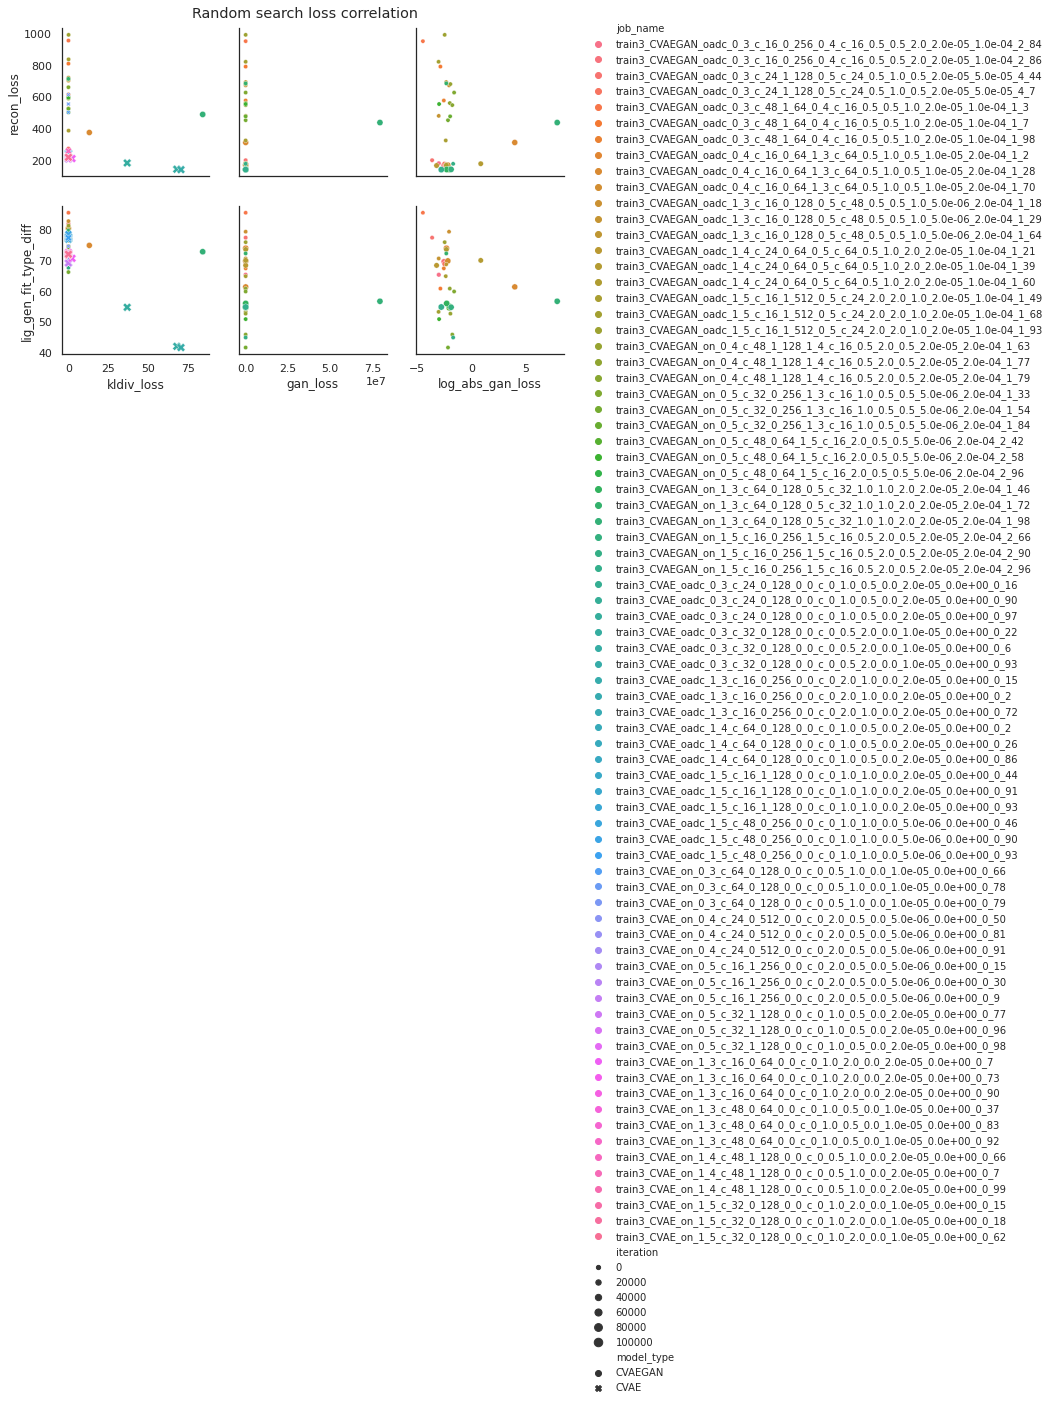

In [201]:
import param_search

hue = 'job_name' #['model_type', 'typer_fns', 'n_latent', 'random_seed']

plot_df = train_metrics
plot_df = plot_df[
    (plot_df['group_name'] == '3') &
    #(plot_df['model_type'] == 'CVAEGAN') &
    #(plot_df['iteration'] >= 200000) &
    (plot_df['recon_loss'] < 1e5) &
    ~(plot_df['gan_loss'] > 1e10) &
    (plot_df['data_phase'] == 'test') &
    True
].groupby(['job_name', 'model_type', 'n_latent']).mean() \
    .reset_index().sort_values(hue)

if set(plot_df['model_type']) == {'CVAE'}:
    plot_df['gan_loss'] = np.nan
plot_df['log_abs_gan_loss'] = np.log10(plot_df['gan_loss'].abs())
plot_df['iteration'] *= 2

fig = param_search.plot(
    plot_df,
    x=['kldiv_loss', 'gan_loss', 'log_abs_gan_loss'],
    y=['recon_loss', 'lig_gen_fit_type_diff'],
    hue=hue,
    n_cols=3,
    width=3,
    height=3,
    plot_func=sns.scatterplot,
    plot_kws=dict(size='iteration', style='model_type'),
    ylim=dict(),
    xlim=dict(),
    legend_kws=dict(
        fontsize='small',
        title=False,
        title_fontsize='medium',
        bbox_to_anchor=(1.1, 1.1),
    ),
    legend_row=0,
    legend_col=-1,
    tight=False,
)

fig.suptitle('Random search loss correlation', y=0.93)
fig.savefig('plots/train3_loss_corr_plot.png')

In [ ]:
# estimate memory usage
KB = 1024
MB = 1024**2
GB = 1024**3

dfs = dict()
df_names = dict()

for name, df in list(locals().items()):
    if isinstance(df, pd.DataFrame):
        if id(df) not in df_names:
            dfs[id(df)] = df
            df_names[id(df)] = []
        df_names[id(df)].append(name)

total_mem = 0
for df_id in dfs:
    df_mem = dfs[df_id].memory_usage(index=True, deep=True).sum() / GB
    print(df_names[df_id], df_mem)
    total_mem += df_mem
    
print(total_mem)

In [202]:
def safe_sem(x):
    return scipy.stats.sem(x) if len(x) > 1 else np.nan

def my_plot(data, x, y, hue, ax, **kwargs):
    for h, hue_data in data.groupby(hue, sort=False):
        hue_data = hue_data[~hue_data[y].isna()]
        try:
            mean = hue_data.groupby(x)[y].agg(np.nanmean)
            sem = hue_data.groupby(x)[y].agg(safe_sem)
            ax.fill_between(mean.index, mean - 2*sem, mean + 2*sem, alpha=0.5, label=h)
            ax.plot(mean.index, mean, label=h) #, marker='x')
        except Exception as e:
            print(e, hue_data[y].dtype, y)
    ax.set_xlabel(x)
    ax.set_ylabel(y)

iter_bin_size = 2500
train_metrics['iter_bin'] = (train_metrics['iteration'] // iter_bin_size) * iter_bin_size

#train_metrics.reset_index(inplace=True)
plot_df = train_metrics

if set(plot_df['model_type']) == {'CVAE'}:
    plot_df['gan_loss'] = np.nan
plot_df['log_abs_gan_loss'] = np.log10(plot_df['gan_loss'].abs())

train_y = [
    'loss',
    'kldiv_loss',
    'recon_loss',
    'gan_loss',
    
    'lig_norm',
    'lig_gen_norm',
    'gen_grad_norm',
    'disc_grad_norm',
    
    'lig_n_atoms',
    'lig_gen_fit_n_atoms',
    'lig_gen_fit_type_diff',
    'log_abs_gan_loss',
    
    'lig_variance',
    'lig_gen_variance',
]
train_x = 'iter_bin'

In [208]:
colors = get_palette(n_hues=64, n_shades=1)
sns.set_palette(colors)
colors

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.9685772133084095, 0.4470348684220113, 0.48246466891236545),
 (0.9693868139978655, 0.4529264415282586, 0.4177396490314462),
 (0.9702448383998029, 0.4590746639084818, 0.331670401478718),
 (0.9688417625390765, 0.46710871459052145, 0.1965441952393453),
 (0.9183238180591338, 0.5026469537693952, 0.19602751520611572),
 (0.8765531794402894, 0.5281127054203663, 0.19562666163714132),
 (0.8406556050916162, 0.5476700629467893, 0.1953010148442934),
 (0.8087954113106306, 0.5634700050056693, 0.19502642696727285),
 (0.7797157520179037, 0.5767517372133368, 0.1947875287593524),
 (0.7524968430969101, 0.5882886691293608, 0.19457395416960102),
 (0.7264168072413041, 0.5985958366311214, 0.1943783290769844),
 (0.7008633391290917, 0.6080365980075504, 0.19419512204856468),
 (0.6752700131937613, 0.6168821571634282, 0.19401994237692713),
 (0.6490616172193203, 0.6253473222212846, 0.19384907864075884),
 (0.6215961626346623, 0.6336137613219601, 0.19367916583134742),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.5594962446241074, 0.6502086029425318, 0.19332884661418084),
 (0.522304439007494, 0.6588723243331578, 0.19314101467753325),
 (0.47810748778716866, 0.6680361348178981, 0.19293861491359926),
 (0.4225883781014591, 0.677943504931845, 0.19271544738133076),
 (0.346376280235058, 0.6889122585711249, 0.19246305874702868),
 (0.21850838711193937, 0.7013812898784881, 0.19216930042759509),
 (0.19512161067678968, 0.6992390765358367, 0.31940698844992155),
 (0.19783576093349015, 0.6955516966063037, 0.3995301037444499),
 (0.2000741067455976, 0.6924491507653744, 0.4538398923952646),
 (0.20198559307245323, 0.6897547200548507, 0.4949468757622348),
 (0.20366709796642735, 0.6873496561826712, 0.5281572829657327),
 (0.20518528131112984, 0.6851497738530601, 0.5562527763557912),
 (0.2065885167903036, 0.6830921394623206, 0.5808902102817125),
 (0.2079138725940713, 0.681126977911426, 0.6031503647343739),
 (0.20919148664422443, 0.6792123798274676, 0.6237935267612539),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.21170649090048915, 0.6753845247945096, 0.6624195284727574),
 (0.21299303515636936, 0.6733956896739991, 0.6812818265204151),
 (0.21433407178514463, 0.6713001302819862, 0.7003768102204219),
 (0.21576108198845112, 0.6690446872415565, 0.7201192992055431),
 (0.21731335755127784, 0.6665609344843629, 0.7409818460947873),
 (0.21904285561010112, 0.6637558151687588, 0.763545185553598),
 (0.22102207407544294, 0.6604959169937373, 0.7885731713670437),
 (0.22335772267769388, 0.6565792317435265, 0.8171355503265633),
 (0.2262161740011972, 0.6516805448369433, 0.8508265764975291),
 (0.22987484843441836, 0.6452359485654354, 0.8921887579440351),
 (0.23483709278892512, 0.6361685864942893, 0.945621052367675),
 (0.3531380715309417, 0.6201408220829481, 0.9586195235634788),
 (0.450325009975823, 0.6031251233924865, 0.958528835084335),
 (0.5245978784733725, 0.5859786064320224, 0.958440699720207),
 (0.5869404500664551, 0.5683319342017273, 0.9583533654930999),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 (0.6935278509735336, 0.529776484222745, 0.9581742744906617),
 (0.7425294389660365, 0.5076850442173546, 0.9580787855101417),
 (0.790806523797355, 0.4825429327842003, 0.95797630556172),
 (0.8397010947263905, 0.4529020995703274, 0.9578638063653008),
 (0.8905877353470529, 0.41635356975626536, 0.9577371994524869),
 (0.9450569493561954, 0.3683695219250479, 0.9575906662391828),
 (0.9589364383737439, 0.3683592173539925, 0.9158732840205942),
 (0.9603888539940703, 0.3814317878772117, 0.8683117650835491),
 (0.9616155171433513, 0.3920794481113146, 0.8252078390086729),
 (0.9626842182576679, 0.40108881303409805, 0.785021011376729),
 (0.9636407990908468, 0.4089576069552029, 0.7465612092834406),
 (0.9645179518697552, 0.41602112206844516, 0.708820872610067),
 (0.9653402631540379, 0.42251843606792194, 0.6708534237157572),
 (0.9661273046909639, 0.42862991134431133, 0.6316625833853154),
 (0.9

CPU times: user 8.29 s, sys: 1.31 s, total: 9.6 s
Wall time: 9.6 s


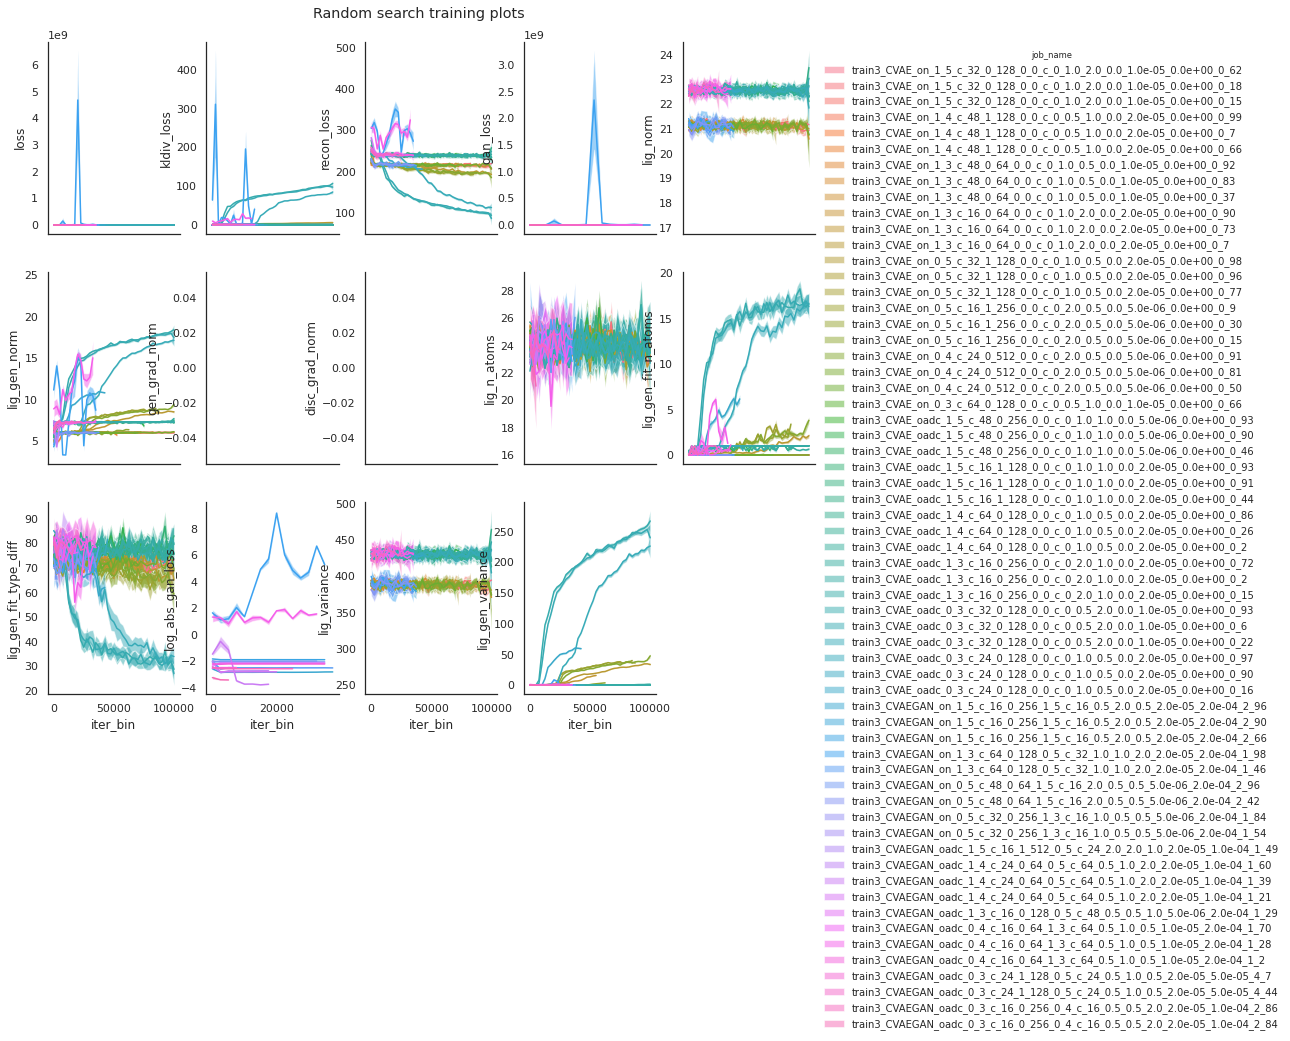

In [209]:
%%time

# everthing but random_seed
hue = 'job_name' #['model_type', 'typer_fns', 'n_latent', 'gen_lr', 'disc_lr', 'random_seed']

fig = param_search.plot(
    plot_df[
        (plot_df['group_name'] == '3') &
        #(plot_df['model_type'] == 'CVAE') &
        (plot_df['data_phase'] == 'test') &
        (plot_df['recon_loss'] < 500) &
        ~(plot_df['gan_loss'] > 1e10) &
        True
    ].sort_values(hue, ascending=False),
    x='iter_bin',
    y=train_y,a
    hue=hue, 
    n_cols=5,
    width=2.75,
    height=4,
    plot_func=my_plot,
    plot_kws=dict(),
    ylim=dict(),
    legend_kws=dict(
        fontsize='small',
        title_fontsize='x-small',
        bbox_to_anchor=(1.00, 1.00),
    ),
    legend_row=0,
    legend_col=-1,
    tight=False,
)
fig.suptitle('Random search training plots', y=0.92)
fig.savefig('plots/train3_training_plots.png')

In [220]:
colors = get_palette(n_hues=8, n_shades=2, n_repeat=1)
sns.set_palette(colors)
colors

[(0.23634883812476926, 0.36540117586720866, 0.6050020969712939),
 (0.4969155015020345, 0.6244882740254134, 0.8593543269793795),
 (0.6836296754496095, 0.39832674778370314, 0.24000718369726198),
 (0.9388929281309761, 0.658358456879028, 0.5014985894353002),
 (0.32515422466361826, 0.5889602898605603, 0.3091027324382589),
 (0.5822039800425122, 0.8488000339600225, 0.5660323650488774),
 (0.6226324552381975, 0.2967960622427579, 0.29678859925849344),
 (0.8747253032841283, 0.5579607142338349, 0.557920545331729),
 (0.4440310965733, 0.3326990926137126, 0.5288393854602685),
 (0.7016766309220037, 0.5925154793520373, 0.7843898229925488),
 (0.4219205276417344, 0.3038780291443622, 0.20359175653545603),
 (0.6793080504068516, 0.5632735915239546, 0.46415417989848295),
 (0.635526089552427, 0.3792918874366735, 0.5587701360021688),
 (0.8907409741786395, 0.6397860888803033, 0.81578658459503),
 (0.3681409186565833, 0.36814277679339824, 0.3681361565035365),
 (0.6271514421767722, 0.6271616320421849, 0.6271216311030934)]

CPU times: user 10.6 s, sys: 325 ms, total: 10.9 s
Wall time: 10.9 s


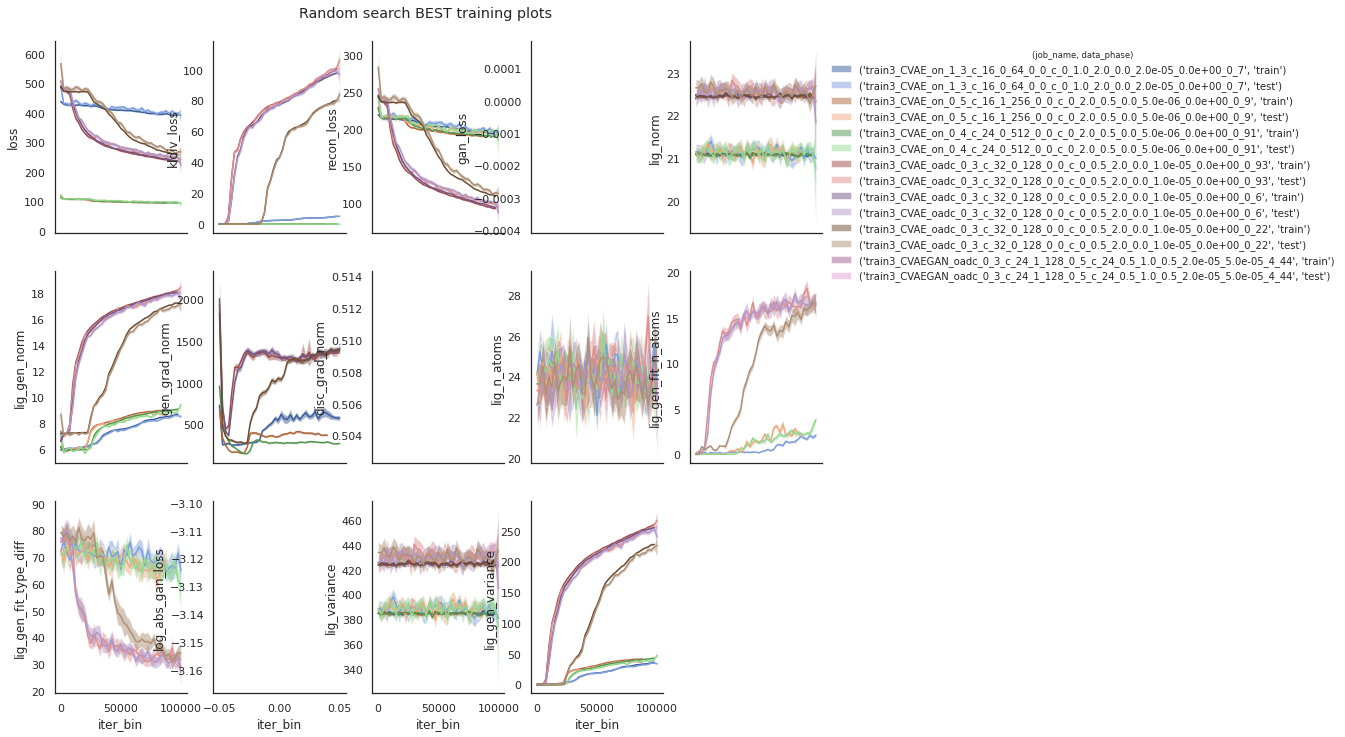

In [224]:
%%time

# everthing but random_seed
hue = ['job_name', 'data_phase'] #['model_type', 'typer_fns', 'n_latent', 'gen_lr', 'disc_lr', 'random_seed']

fig = param_search.plot(
    plot_df[
        (plot_df['group_name'] == '3') &
        #(plot_df['model_type'] == 'CVAE') &
        #(plot_df['data_phase'] == 'test') &
        plot_df['job_name'].isin(
            train_jobs[train_jobs['test_recon_loss'] < 200]['job_name'].unique()
        ) &
        True
    ].sort_values(hue, ascending=False),
    x='iter_bin',
    y=train_y,
    hue=hue, 
    n_cols=5,
    width=2.75,
    height=4,
    plot_func=my_plot,
    plot_kws=dict(),
    ylim=dict(),
    legend_kws=dict(
        fontsize='small',
        title_fontsize='x-small',
        bbox_to_anchor=(1.00, 1.00),
    ),
    legend_row=0,
    legend_col=-1,
    tight=False,
)
fig.suptitle('Random search BEST training plots', y=0.92)
fig.savefig('plots/train3_best_training_plots.png')

In [228]:
resub_jobs = train_jobs[
    (train_jobs['group_name'] == 3) &
    (train_jobs['test_recon_loss'] < 200)
]
resub_jobs.set_index(['job_name', 'job_id']) \
    .sort_values(['job_name_idx', 'job_id'])[[
    'runtime', 'node_id', 'job_state',
    'iteration',
    'train_recon_loss', 'test_recon_loss', 'test_type_diff',
    #'stdout_train', 'stdout_test',
    'stderr',
]]

,,runtime,node_id,job_state,iteration,train_recon_loss,test_recon_loss,test_type_diff,stderr
job_name,job_id,,,,,,,,
train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_93,6879528,NaN,NaN,OK,100000.0,93.6070,94.4280,28.82,None
train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_22,6879529,NaN,NaN,OK,100000.0,113.0989,113.0220,33.99,None
train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_6,6879530,NaN,NaN,OK,100000.0,87.8927,86.8480,27.08,None
train3_CVAE_on_0_4_c_24_0_512_0_0_c_0_2.0_0.5_0.0_5.0e-06_0.0e+00_0_91,6879544,NaN,NaN,OK,100000.0,164.9981,185.4171,59.36,None
train3_CVAE_on_0_5_c_16_1_256_0_0_c_0_2.0_0.5_0.0_5.0e-06_0.0e+00_0_9,6879582,18:11:43,g003,R,88780.0,188.4365,193.4170,NaN,None
train3_CVAE_on_1_3_c_16_0_64_0_0_c_0_1.0_2.0_0.0_2.0e-05_0.0e+00_0_7,6879603,NaN,NaN,OK,100000.0,149.9583,192.9060,65.01,None
train3_CVAEGAN_oadc_0_3_c_24_1_128_0_5_c_24_0.5_1.0_0.5_2.0e-05_5.0e-05_4_44,6879634,7:33:07,g008,R,8369.0,NaN,186.4845,NaN,None


In [229]:
param_search.job_queues.verbose = True
param_search.submit(resub_jobs['job_file'])

sbatch /net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_93/train.sh
sbatch /net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_22/train.sh
sbatch /net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_6/train.sh
sbatch /net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train3_CVAE_on_0_4_c_24_0_512_0_0_c_0_2.0_0.5_0.0_5.0e-06_0.0e+00_0_91/train.sh
sbatch /net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train3_CVAE_on_0_5_c_16_1_256_0_0_c_0_2.0_0.5_0.0_5.0e-06_0.0e+00_0_9/train.sh
sbatch /net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train3_CVAE_on_1_3_c_16_0_64_0_0_c_0_1.0_2.0_0.0_2.0e-05_0.0e+00_0_7/train.sh
sbatch /net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train3_CVAEGAN_oadc_0_3_c_24_1_128_0_5_c_24_0.5_1.0_0.5_2.0e-05_5.0e-0

[6889371, 6889372, 6889373, 6889374, 6889375, 6889376, 6889377]

In [ ]:
train_metrics.columns

In [ ]:
time_cols = ['forward_data_time', 'forward_gen_time', 'forward_fit_time', 'forward_metrics_time', 'forward_time']
plot_df = train_metrics.groupby('job_name')[time_cols].sum()
plot_df = (plot_df.apply(lambda x: x / x[time_cols[-1]], axis=1) * 100)[time_cols[:-1]].mean().plot(kind='bar')
train_metrics.groupby('job_name')[time_cols].mean().mean()

In [ ]:
time_cols = ['backward_grad_time', 'backward_norm_time', 'backward_update_time', 'backward_time']
plot_df = train_metrics.groupby('job_name')[time_cols].sum()
(plot_df.apply(lambda x: x / x[time_cols[-1]], axis=1) * 100)[time_cols[:-1]].mean().plot(kind='bar')
train_metrics.groupby('job_name')[time_cols].mean().mean()

In [ ]:
train_metrics.to_csv('train2_100k_backup.train_metrics')

In [ ]:
save_cols = 'iteration data_phase batch loss recon_loss kldiv_loss lig_norm lig_variance lig_gen_norm lig_gen_variance lig_gen_L2_loss lig_gen_fit_n_atoms lig_gen_fit_radius lig_n_atoms lig_radius lig_gen_fit_type_diff lig_gen_fit_exact_types lig_gen_fit_atom_rmsd forward_data_time forward_gen_time forward_fit_time forward_metrics_time forward_time forward_gpu memory'.split(' ')
for job_name, job_metrics in train_metrics.groupby('job_name'):
    metrics_file = job_name + '/' + job_name + '.train_metrics'
    job_metrics[save_cols].to_csv(metrics_file, sep=' ', header=True, index=False)
    print(metrics_file)